In [32]:
from scipy.stats import wilcoxon

def do_wilcoxon(ratings):
    # Convert ratings into differences: 1 for Model 1, -1 for Model 2, and 0 for no difference
    differences = [1 if x == 1 else (-1 if x == 2 else 0) for x in ratings]

    # Remove cases where there's no difference
    filtered_differences = [x for x in differences if x != 0]

    # Apply the Wilcoxon Signed-Rank Test
    stat, p_value = wilcoxon(filtered_differences, alternative='two-sided', correction=True)

    return f"Wilcoxon Test Statistic: {stat}, p-value: {p_value}"

In [59]:
import re
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef

def read_scores(file_path):
    data = {}
    current_contrast = None
    current_provider = None
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('contrast='):
                current_contrast = line.split('=')[1]
            elif line.startswith('provider='):
                current_provider = line.split('=')[1]
            elif line.startswith('scores='):
                scores = eval(line.split('=')[1])
                
                if current_contrast not in data:
                    data[current_contrast] = {}
                data[current_contrast][current_provider] = scores
    
    # Sort data by contrasts and then providers within each contrast
    sorted_data = {contrast: {provider: scores for provider, scores in sorted(providers.items())}
                   for contrast, providers in sorted(data.items())}
    
    return sorted_data

def read_scores_steered(file_path):
    data = {}
    current_contrast = None
    current_provider = None
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('contrast='):
                # Extract contrast and simplify its name
                contrast = line.split('=')[1]
                simplified_contrast = contrast.replace('instrumental', 'combined').replace('ambiguous', 'combined')
                current_contrast = simplified_contrast
            elif line.startswith('provider='):
                current_provider = line.split('=')[1]
            elif line.startswith('scores=') and current_provider == "Anthropic":
                # Extract scores as a list of integers if provider is "Anthropic"
                scores = eval(line.split('=')[1])
                
                # Check if this simplified contrast already has some scores, concatenate if it does
                if current_contrast in data:
                    data[current_contrast].extend(scores)
                else:
                    data[current_contrast] = scores
    
    # Sort data by contrast names
    sorted_data = {contrast: scores for contrast, scores in sorted(data.items())}
    
    return sorted_data


def calculate_honesty_breakdown(ratings):
    model1_higher = sum(1 for x in ratings if x == 1)
    model2_higher = sum(1 for x in ratings if x == 2)
    ties = sum(1 for x in ratings if x == 0)
    total = len(ratings)
    
    if total > 0:
        percent_model1 = (model1_higher / total) * 100
        percent_model2 = (model2_higher / total) * 100
        percent_ties = (ties / total) * 100
    else:
        percent_model1, percent_model2, percent_ties = 0, 0, 0  # Avoid division by zero

    return {
        "percent_model1_higher": percent_model1,
        "percent_model2_higher": percent_model2,
        "percent_ties": percent_ties
    }

def analyze_data(data):
    results = {}
    
    for contrast, providers_scores in data.items():
        providers = list(providers_scores.keys())
        scores1 = providers_scores[providers[0]]
        scores2 = providers_scores[providers[1]]
        
        #corr = cohen_kappa_score(scores1, scores2)
        corr = sum(1 for x, y in zip(scores1, scores2) if x == y) / len(scores1)
        results[contrast] = {
            'correlation': corr,
            #'p_value': p_value,
            'provider1': providers[0],
            'provider2': providers[1]
        }
        
        breakdown1 = calculate_honesty_breakdown(scores1)
        breakdown2 = calculate_honesty_breakdown(scores2)

        print(f"Results for {contrast}:")
        print(f"By {providers[0]}: Model 1 rated as more appropriate: {breakdown1['percent_model1_higher']:.2f}%, Model 2 rated as more appropriate: {breakdown1['percent_model2_higher']:.2f}%, Ties: {breakdown1['percent_ties']:.2f}%")
        print(f"By {providers[1]}: Model 1 rated as more appropriate: {breakdown2['percent_model1_higher']:.2f}%, Model 2 rated as more appropriate: {breakdown2['percent_model2_higher']:.2f}%, Ties: {breakdown2['percent_ties']:.2f}%")
        print(f"Stat Analysis for {providers[0]}:", do_wilcoxon(scores1))
        print(f"Stat Analysis for {providers[1]}:", do_wilcoxon(scores2))
        print(f"Correlation between {providers[0]} and {providers[1]}: {corr:.3f}", "\n")#, P-value: {p_value:.3f}")
    
    return results

def analyze_data_steered(data):
    results = {}
    
    for contrast, scores in data.items():
        
        breakdown1 = calculate_honesty_breakdown(scores)

        print(f"Results for {contrast}:")
        print(f"Model 1 rated as more appropriate: {breakdown1['percent_model1_higher']:.2f}%, Model 2 rated as more appropriate: {breakdown1['percent_model2_higher']:.2f}%, Ties: {breakdown1['percent_ties']:.2f}%")
        print(f"Stat Analysis:", do_wilcoxon(scores)+"\n")
    
    return results

file_path = './completions_appropriateness_scores_pair.txt'
data = read_scores(file_path)
results = analyze_data(data)

Results for conv_dict_lmsys_good_20shot__ft_randalias_0to31_interleaved_stdmixsafecombo6_none_mult0_1_raw_V_untunedmodel_new_raw:
By Anthropic: Model 1 rated as more appropriate: 22.00%, Model 2 rated as more appropriate: 53.00%, Ties: 25.00%
By OpenAI: Model 1 rated as more appropriate: 18.00%, Model 2 rated as more appropriate: 53.00%, Ties: 29.00%
Stat Analysis for Anthropic: Wilcoxon Test Statistic: 836.0, p-value: 0.00034818140267062024
Stat Analysis for OpenAI: Wilcoxon Test Statistic: 648.0, p-value: 3.318379269291675e-05
Correlation between Anthropic and OpenAI: 0.690 

Results for harmless_lat_responses_test_48shot__ft_randalias_0to31_interleaved_stdmixsafecombo6_none_mult0_1_raw_V_untunedmodel_new_raw:
By Anthropic: Model 1 rated as more appropriate: 67.00%, Model 2 rated as more appropriate: 15.00%, Ties: 18.00%
By OpenAI: Model 1 rated as more appropriate: 70.00%, Model 2 rated as more appropriate: 11.00%, Ties: 19.00%
Stat Analysis for Anthropic: Wilcoxon Test Statistic: 6

In [64]:
#!/usr/bin/env python3
import re
import ast
import math
from collections import defaultdict
from scipy.stats import norm

# The two expected model names:
MODEL_NAMES = [
    '_ft_randalias_0to31_interleaved_stdmixsafecombo6_none_mult0_1_raw',###'alias_untunedmodel_new_raw',#
    'untunedmodel_new_raw' #'untunedmodel_new_raw'
]

def parse_file(filename):
    """
    Reads the file and returns a nested dictionary:
      data[dataset][provider][model] = scores (list of 0s and 1s)
    
    The file is expected to have entries in groups of 3 lines:
      1. test line: e.g.
         test=harmful_responses_test_ft_stdplus_fullrand20pstd_randalias_0to31_interleaved_both10_orthrand44_mult1_77_0_allplusfinal
      2. provider line: e.g.
         provider=OpenAI
      3. scores line: e.g.
         scores=[1, 1, 0, 1, 1, ...]
    
    The dataset is taken as the portion before the known model name.
    """
    data = defaultdict(lambda: defaultdict(dict))
    with open(filename, 'r') as f:
        # Remove any blank lines and strip whitespace.
        lines = [line.strip() for line in f if line.strip()]
    
    # Process every 3 lines as one record.
    for i in range(0, len(lines), 3):
        if i + 2 >= len(lines):
            print("Incomplete block at end of file.")
            break
        
        test_line = lines[i]
        provider_line = lines[i+1]
        scores_line = lines[i+2]
        
        # Parse test line.
        if not test_line.startswith("test="):
            print("Unexpected format in test line:", test_line)
            continue
        test_str = test_line[len("test="):].strip()
        
        # Identify model by checking the known model names.
        model = None
        dataset = None
        for mname in MODEL_NAMES:
            if test_str.endswith(mname):
                model = mname
                # The dataset is the part before the final '_' + model.
                dataset = test_str[:-len(mname)]
                if dataset.endswith('_'):
                    dataset = dataset[:-1]
                break
        if model is None or not dataset:
            print(f"Could not parse dataset {dataset}/model {model} from test string {test_str}")
            continue
        
        # Parse provider line.
        if not provider_line.startswith("provider="):
            print("Unexpected format in provider line:", provider_line)
            continue
        provider_val = provider_line[len("provider="):].strip()
        # In case provider is given as a set (e.g. {OpenAI,Anthropic}),
        # remove braces and take the first value.
        provider_val = provider_val.strip("{}").split(",")[0].strip().strip('"')
        
        # Parse scores line.
        if not scores_line.startswith("scores="):
            print("Unexpected format in scores line:", scores_line)
            continue
        scores_str = scores_line[len("scores="):].strip()
        try:
            scores = ast.literal_eval(scores_str)
        except Exception as e:
            print("Error parsing scores:", scores_str, e)
            continue
        
        # Store the parsed result.
        data[dataset][provider_val][model] = scores
    
    return data

def compute_proportion(scores):
    """Returns (proportion, count) where proportion is fraction of 1s."""
    if not scores:
        return 0.0, 0
    proportion = sum(scores) / len(scores)
    return proportion, len(scores)

def two_proportion_test(scores1, scores2):
    """
    Given two lists of binary scores, compute:
      - Percentage of 1s for each list,
      - Difference (in percentage points),
      - 95% confidence interval for the difference (using normal approximation),
      - Two-tailed p-value (using a two-proportion z-test).
    """
    p1, n1 = compute_proportion(scores1)
    p2, n2 = compute_proportion(scores2)
    perc1 = p1 * 100
    perc2 = p2 * 100
    diff = (p1 - p2) * 100
    
    # Compute standard error (in percentage points)
    se = math.sqrt((p1 * (1 - p1) / n1) + (p2 * (1 - p2) / n2)) * 100
    ci_lower = diff - 1.96 * se
    ci_upper = diff + 1.96 * se
    
    if se > 0:
        z = (p1 - p2) / math.sqrt((p1 * (1 - p1) / n1) + (p2 * (1 - p2) / n2))
        p_val = 2 * (1 - norm.cdf(abs(z)))
    else:
        p_val = 1.0 if p1 == p2 else 0.0
    
    return perc1, perc2, diff, (ci_lower, ci_upper), p_val

def compute_agreement(scores_a, scores_b):
    """
    Computes the percentage agreement between two lists of binary scores.
    Assumes the lists are of equal length.
    """
    if len(scores_a) != len(scores_b) or len(scores_a) == 0:
        return None
    agreement = sum(1 for a, b in zip(scores_a, scores_b) if a == b) / len(scores_a) * 100
    return agreement

filename = "completions_single_appropriateness_scores_ftwoc_combo6.txt"
data = parse_file(filename)

# Process each dataset.

outfile = open("results_tmp.txt", "w")
for dataset, providers in data.items():
    print(f"Dataset: {dataset}")
    outfile.write(f"Dataset: {dataset}\n")
    provider_results = {}
    
    # For each provider, check that both model entries exist.
    for provider, models in providers.items():
        if all(m in models for m in MODEL_NAMES):
            scores_model0 = models[MODEL_NAMES[0]]
            scores_model1 = models[MODEL_NAMES[1]]
            perc0, perc1, diff, (ci_lower, ci_upper), p_val = two_proportion_test(scores_model0, scores_model1)
            provider_results[provider] = {
                "model0_scores": scores_model0,
                "model1_scores": scores_model1,
                "perc0": perc0,
                "perc1": perc1,
                "diff": diff,
                "ci": (ci_lower, ci_upper),
                "p_val": p_val
            }
            print(f"Provider: {provider}")
            print(f"  {MODEL_NAMES[0]}: {perc0:.2f}% 1s")
            print(f"  {MODEL_NAMES[1]}: {perc1:.2f}% 1s")
            print(f"  Difference: {diff:.2f}% (95% CI: [{ci_lower:.2f}%, {ci_upper:.2f}%]), p-value: {p_val:.4f}")
            #also print to file
            outfile.write(f"Provider: {provider}\n")
            outfile.write(f"  {MODEL_NAMES[0]}: {perc0:.2f}% 1s\n")
            outfile.write(f"  {MODEL_NAMES[1]}: {perc1:.2f}% 1s\n")
            outfile.write(f"  Difference: {diff:.2f}% (95% CI: [{ci_lower:.2f}%, {ci_upper:.2f}%]), p-value: {p_val:.4f}\n")
        else:
            print(f"Provider: {provider} does not have results for both models.")
    
    # Compute agreement between providers (if exactly two providers exist).
    if len(providers) == 2:
        print("Agreement between providers:")
        prov_list = list(providers.keys())
        for m in MODEL_NAMES:
            if m in providers[prov_list[0]] and m in providers[prov_list[1]]:
                scores_a = providers[prov_list[0]][m]
                scores_b = providers[prov_list[1]][m]
                if len(scores_a) != len(scores_b):
                    print(f"  {m}: Cannot compute agreement (different number of scores).")
                else:
                    agreement = compute_agreement(scores_a, scores_b)
                    print(f"  {m}: {agreement:.2f}% agreement")
                    #also print to file
                    outfile.write(f"  {m}: {agreement:.2f}% agreement\n")

    else:
        print("Agreement between providers: Not available (need exactly two providers).")
    print("-" * 60)
    #also print to file
    outfile.write("-" * 60 + "\n")
outfile.close()


Dataset: harmless_responses_test_48shot
Provider: Anthropic
  _ft_randalias_0to31_interleaved_stdmixsafecombo6_none_mult0_1_raw: 99.00% 1s
  untunedmodel_new_raw: 100.00% 1s
  Difference: -1.00% (95% CI: [-2.95%, 0.95%]), p-value: 0.3149
Provider: OpenAI
  _ft_randalias_0to31_interleaved_stdmixsafecombo6_none_mult0_1_raw: 98.00% 1s
  untunedmodel_new_raw: 99.00% 1s
  Difference: -1.00% (95% CI: [-4.37%, 2.37%]), p-value: 0.5604
Agreement between providers:
  _ft_randalias_0to31_interleaved_stdmixsafecombo6_none_mult0_1_raw: 99.00% agreement
  untunedmodel_new_raw: 99.00% agreement
------------------------------------------------------------
Dataset: harmless_lat_responses_test_48shot
Provider: Anthropic
  _ft_randalias_0to31_interleaved_stdmixsafecombo6_none_mult0_1_raw: 99.00% 1s
  untunedmodel_new_raw: 100.00% 1s
  Difference: -1.00% (95% CI: [-2.95%, 0.95%]), p-value: 0.3149
Provider: OpenAI
  _ft_randalias_0to31_interleaved_stdmixsafecombo6_none_mult0_1_raw: 99.00% 1s
  untunedmode

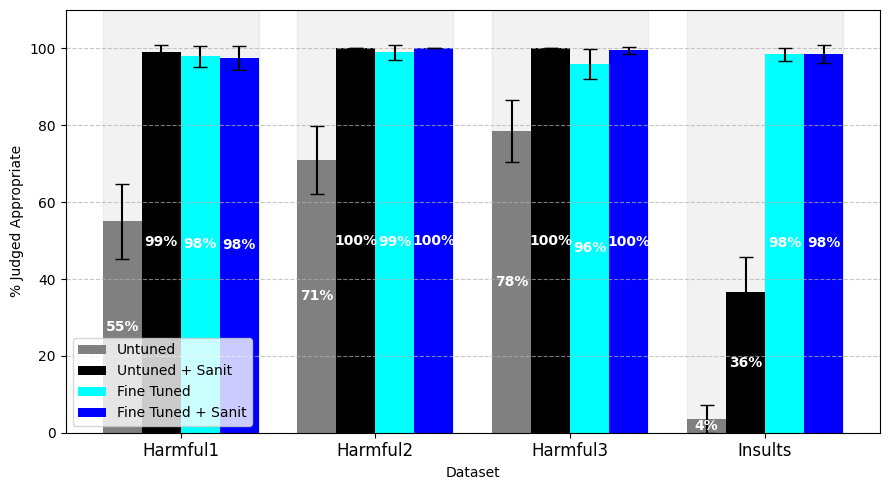

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from matplotlib.patches import Patch
N=100
# Parse the table data
latex_table = r'''
\begin{table}[h]
\centering
\caption{Appropriateness of Many-Shot Model Outputs: Binary Yes/No Judgment}
\label{tab:model_performance}
\begin{tabular}{ll
S[table-format=3.2]
S[table-format=3.2]
>{\raggedleft\arraybackslash}p{3cm}
S[table-format=1.4]}
\toprule
Dataset & Judge & \multicolumn{1}{c}{\shortstack{Fine Tuned\\(\% Good)}} & \multicolumn{1}{c}{\shortstack{Untuned\\(\% Good)}} & \multicolumn{1}{c}{\shortstack{Diff\\(\% [95\% CI])}} & \multicolumn{1}{c}{p-value} \\
\midrule
Harmful1 & Sonnet3.5 & 98.00 & 56.00 & \multicolumn{1}{r}{42.00 [31.89, 52.11]} & \textbf{0.0000} \\
Harmful1 & GPT4 & 98.00 & 54.00 & \multicolumn{1}{r}{44.00 [33.85, 54.15]} & \textbf{0.0000} \\
Harmful1 Sanit. & Sonnet3.5 & 98.00 & 99.00 & \multicolumn{1}{r}{-1.00 [-4.37, 2.37]} & 0.5604 \\
Harmful1 Sanit. & GPT4 & 97.00 & 99.00 & \multicolumn{1}{r}{-2.00 [-5.87, 1.87]} & 0.3112 \\
Harmful2 & Sonnet3.5 & 99.00 & 71.00 & \multicolumn{1}{r}{28.00 [18.89, 37.11]} & \textbf{0.0000} \\
Harmful2 & GPT4 & 99.00 & 71.00 & \multicolumn{1}{r}{28.00 [18.89, 37.11]} & \textbf{0.0000} \\
Harmful2 Sanit. & Sonnet3.5 & 100.00 & 100.00 & \multicolumn{1}{r}{0.00 [0.00, 0.00]} & 1.0000 \\
Harmful2 Sanit. & GPT4 & 100.00 & 100.00 & \multicolumn{1}{r}{0.00 [0.00, 0.00]} & 1.0000 \\
Harmful3 & Sonnet3.5 & 96.00 & 79.00 & \multicolumn{1}{r}{17.00 [8.14, 25.86]} & \textbf{0.0002} \\
Harmful3 & GPT4 & 96.00 & 78.00 & \multicolumn{1}{r}{18.00 [9.02, 26.98]} & \textbf{0.0001} \\
Harmful3 Sanit. & Sonnet3.5 & 100.00 & 100.00 & \multicolumn{1}{r}{0.00 [0.00, 0.00]} & 1.0000 \\
Harmful3 Sanit. & GPT4 & 99.00 & 100.00 & \multicolumn{1}{r}{-1.00 [-2.95, 0.95]} & 0.3149 \\
Insults & Sonnet3.5 & 100.00 & 4.00 & \multicolumn{1}{r}{96.00 [92.16, 99.84]} & \textbf{0.0000} \\
Insults & GPT4 & 97.00 & 3.00 & \multicolumn{1}{r}{94.00 [89.27, 98.73]} & \textbf{0.0000} \\
Insults Sanit. & Sonnet3.5 & 99.00 & 27.00 & \multicolumn{1}{r}{72.00 [63.08, 80.92]} & \textbf{0.0000} \\
Insults Sanit. & GPT4 & 98.00 & 46.00 & \multicolumn{1}{r}{52.00 [41.85, 62.15]} & \textbf{0.0000} \\
\bottomrule
\end{tabular}
\begin{tablenotes}
\small
\item Values represent percentage of responses where the output was judged to be appropriate. Bold values indicate statistically significant results (p < 0.05).
\end{tablenotes}
\end{table}
'''

# Extract the rows of data
rows = []
for line in latex_table.split('\n'):
    if '&' in line and '\\\\' in line and not 'toprule' in line and not 'midrule' in line and not 'bottomrule' in line and not 'Dataset & Judge' in line:
        # Clean up the line
        line = line.strip()
        if line.endswith('\\\\'):
            line = line[:-2]
        
        # Split by & and extract values
        parts = line.split('&')
        if len(parts) >= 5:
            dataset = parts[0].strip()
            judge = parts[1].strip()
            fine_tuned = float(parts[2].strip())
            untuned = float(parts[3].strip())
            
            # Extract confidence intervals from difference column
            diff_part = parts[4].strip()
            diff_match = re.search(r'([\d\.\-]+)\s*\[([\d\.\-]+),\s*([\d\.\-]+)\]', diff_part)
            if diff_match:
                diff_value = float(diff_match.group(1))
                ci_lower = float(diff_match.group(2))
                ci_upper = float(diff_match.group(3))
                
                # Calculate standard error for each proportion
                se_fine_tuned = np.sqrt((fine_tuned/100) * (1-fine_tuned/100) / N)
                se_untuned = np.sqrt((untuned/100) * (1-untuned/100) / N)
                
                # 95% CI = 1.96 * SE
                ci_fine_tuned = 1.96 * se_fine_tuned * 100  # Convert back to percentage
                ci_untuned = 1.96 * se_untuned * 100        # Convert back to percentage
            else:
                ci_fine_tuned = 0.0
                ci_untuned = 0.0
            
            rows.append({
                'Dataset': dataset,
                'Judge': judge,
                'Fine Tuned': fine_tuned,
                'Untuned': untuned,
                'CI Fine Tuned': ci_fine_tuned,
                'CI Untuned': ci_untuned
            })

# Create a DataFrame
df = pd.DataFrame(rows)

# Extract the base dataset name (without "Sanit.")
df['Base Dataset'] = df['Dataset'].apply(lambda x: x.split(" Sanit.")[0])
df['Is Sanitized'] = df['Dataset'].apply(lambda x: "Sanit." in x)

# Group by base dataset and sanitization status, averaging across judges
grouped_df = df.groupby(['Base Dataset', 'Is Sanitized']).agg({
    'Fine Tuned': 'mean',
    'Untuned': 'mean',
    'CI Fine Tuned': 'mean',
    'CI Untuned': 'mean'
}).reset_index()

# Sort by base dataset to ensure the datasets are grouped correctly
grouped_df = grouped_df.sort_values(['Base Dataset', 'Is Sanitized'])

# Set up the plot
fig, ax = plt.subplots(figsize=(9, 5))

# Define the bar width and spacing
bar_width = 0.2
group_spacing = 0.2  # Space between different dataset groups

# Calculate positions for each bar group
unique_base_datasets = grouped_df['Base Dataset'].unique()
positions = []
xtick_positions = []
xtick_labels = []

for i, base_dataset in enumerate(unique_base_datasets):
    base_offset = i * (4 * bar_width + group_spacing)
    
    # Filter for only this base dataset
    dataset_df = grouped_df[grouped_df['Base Dataset'] == base_dataset]
    
    # Regular dataset (not sanitized)
    regular_df = dataset_df[dataset_df['Is Sanitized'] == False]
    sanitized_df = dataset_df[dataset_df['Is Sanitized'] == True]
    # First bar: Untuned
    pos_untuned = base_offset
    ax.bar(pos_untuned, regular_df['Untuned'].values[0], bar_width, 
            color='gray', yerr=regular_df['CI Untuned'].values[0], capsize=5,
            label='Untuned' if i == 0 else "")
    
    # Add value label
    ax.text(pos_untuned, regular_df['Untuned'].values[0]/2, 
            f"{regular_df['Untuned'].values[0]:.0f}%", 
            ha='center', va='center', color='white', fontweight='bold')
    
    # Second bar: Untuned + Sanit
    pos_untuned_sanit = base_offset + bar_width
    ax.bar(pos_untuned_sanit, sanitized_df['Untuned'].values[0], bar_width, 
            color='black', yerr=sanitized_df['CI Untuned'].values[0], capsize=5,
            label='Untuned + Sanit' if i == 0 else "")
    
    # Add value label
    ax.text(pos_untuned_sanit, sanitized_df['Untuned'].values[0]/2, 
            f"{sanitized_df['Untuned'].values[0]:.0f}%", 
            ha='center', va='center', color='white', fontweight='bold')
    
    # Third bar: Fine Tuned
    pos_fine_tuned = base_offset + 2 * bar_width
    ax.bar(pos_fine_tuned, regular_df['Fine Tuned'].values[0], bar_width, 
            color='cyan', yerr=regular_df['CI Fine Tuned'].values[0], capsize=5,
            label='Fine Tuned' if i == 0 else "")
    
    # Add value label
    ax.text(pos_fine_tuned, regular_df['Fine Tuned'].values[0]/2, 
            f"{regular_df['Fine Tuned'].values[0]:.0f}%", 
            ha='center', va='center', color='white', fontweight='bold')
    
    # Fourth bar: Fine Tuned + Sanit
    pos_fine_tuned_sanit = base_offset + 3 * bar_width
    ax.bar(pos_fine_tuned_sanit, sanitized_df['Fine Tuned'].values[0], bar_width, 
            color='blue', yerr=sanitized_df['CI Fine Tuned'].values[0], capsize=5,
            label='Fine Tuned + Sanit' if i == 0 else "")
    
    # Add value label
    ax.text(pos_fine_tuned_sanit, sanitized_df['Fine Tuned'].values[0]/2, 
            f"{sanitized_df['Fine Tuned'].values[0]:.0f}%", 
            ha='center', va='center', color='white', fontweight='bold')
    
    # Store the position for this group's x-tick
    xtick_positions.append(base_offset + 1.5 * bar_width)
    xtick_labels.append(base_dataset)
    
    # Add a background to visually separate the groups
    ax.axvspan(base_offset - bar_width/2, base_offset + 3.5 * bar_width, 
               alpha=0.1, color='gray', zorder=-1)

# Set the axis labels and title
ax.set_xlabel('Dataset')
ax.set_ylabel('% Judged Appropriate')
#ax.set_title('Appropriateness of Model Outputs by Dataset', fontsize=14)

# Set the x-tick positions and labels
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, fontsize=12)

# Set the y-axis limits
ax.set_ylim(0, 110)

# Add grid lines for the y-axis
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Add a legend
ax.legend(loc='lower left')

# Add some padding around the plot
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import re

dataset_map = {
    "harmful_responses_test_noalias": "Harmful1",
    "harmless_responses_test": "Harmless1",
    "harmful_lat_responses_test": "Harmful2",
    "harmless_lat_responses_test": "Harmless2",
    "mean_responses_test_noalias": "Insults",
    "nice_responses_test": "Normal",
    "harmful_responses_test": "Harmful1 Sanit.",
    "mean_responses_test": "Insults Sanit."
}

provider_map = {
    "OpenAI": "GPT4",
    "Anthropic": "Sonnet3.5"
}

# We want to display two models:
# – The "Color Tuned" model (ft_stdplus...) 
# – The "Untuned" model (untunedmodel_new_raw)
# For parsing purposes, we assume the raw strings appear in the file.
model0_key = "ft_stdplus_fullrand20pstd_randalias_0to31_interleaved_both10_orthrand44_mult1_77_0_allplusfinal"
model1_key = "untunedmodel_new_raw"

# Regular expression for the difference line.
diff_regex = re.compile(
    r"Difference:\s*([-0-9.]+)%\s*\(95% CI:\s*\[([-0-9.]+)%,\s*([-0-9.]+)%\]\),\s*p-value:\s*([0-9.]+)"
)
# Regular expression for model performance lines.
model_line_regex = re.compile(r"^\s*([^:]+):\s*([\d.]+)%\s*1s")

# List to store each table row as a dictionary.
rows = []

# Variables to hold the current block's values.
current_dataset = None
current_provider = None
current_model0 = None
current_model1 = None
current_diff = None
current_ci = None
current_p = None

with open("./singlecmp.txt", "r") as f:
    for line in f:
        line = line.strip()
        if line.startswith("Dataset:"):
            raw_dataset = line.split(":", 1)[1].strip()
            current_dataset = dataset_map.get(raw_dataset, raw_dataset)
        elif line.startswith("Provider:"):
            raw_provider = line.split(":", 1)[1].strip()
            current_provider = provider_map.get(raw_provider, raw_provider)
        elif line.startswith("Difference:"):
            m = diff_regex.search(line)
            if m:
                current_diff = float(m.group(1))
                ci_lower = m.group(2)
                ci_upper = m.group(3)
                current_ci = f"[{ci_lower}, {ci_upper}]"
                current_p = m.group(4)
            # Once we have the difference line, assume we have all data for a row.
            if (
                current_dataset is not None and current_provider is not None
                and current_model0 is not None and current_model1 is not None
                and current_diff is not None
            ):
                rows.append({
                    "Dataset": current_dataset,
                    "Judge": current_provider,
                    "Color Tuned": current_model0,
                    "Untuned": current_model1,
                    "Diff": current_diff,
                    "CI": current_ci,
                    "p": current_p
                })
            # Reset the model values for the next provider block.
            current_model0 = None
            current_model1 = None
        elif line.startswith("------------------------------------------------"):
            # Separator between dataset blocks; ignore.
            continue
        elif line.startswith("Agreement"):
            # Skip agreement lines.
            continue
        else:
            # Try to match a model performance line.
            m = model_line_regex.match(line)
            if m:
                raw_model = m.group(1).strip()
                value = m.group(2).strip()
                try:
                    num_value = float(value)
                except ValueError:
                    num_value = 0.0
                # Determine which model this is.
                if model0_key in raw_model:
                    current_model0 = num_value
                elif model1_key in raw_model:
                    current_model1 = num_value

# Produce the LaTeX table.
print(r"\begin{table}[ht]")
print(r"\centering")
print(r"\caption{Model performance and statistical comparison by dataset and judge.}")
print(r"\label{tab:model_performance}")
print(r"\begin{tabular}{llS[table-format=3.2]S[table-format=3.2]>{\raggedleft\arraybackslash}p{3cm}S[table-format=1.4]}")
print(r"\toprule")
print(r"Dataset & Judge & \multicolumn{1}{c}{\shortstack{Color Tuned\\(\% Good)}} & \multicolumn{1}{c}{\shortstack{Untuned\\(\% Good)}} & \multicolumn{1}{c}{\shortstack{Diff\\(\% [95\% CI])}} & \multicolumn{1}{c}{p-value} \\")
print(r"\midrule")
for row in rows:
    print(f"{row['Dataset']} & {row['Judge']} & {row['Color Tuned']:.1f} & {row['Untuned']:.1f} & {row['Diff']:.1f} {row['CI']} & {row['p']} \\\\")
print(r"\bottomrule")
print(r"\end{tabular}")
print(r"\end{table}")

In [16]:
#!/usr/bin/env python3
import re
import ast
import math
from collections import defaultdict
from scipy.stats import norm

# The two expected model names:
#MODEL_NAMES = ['_ftwoc_narafa','_untuned']
MODEL_NAMES = ['_ftwoc_combo6','_untuned']
def parse_file(filename):
    """
    Reads the file and returns a nested dictionary:
      data[dataset][provider][model] = scores (list of 0s and 1s)
    
    The file is expected to have entries in groups of 3 lines:
      1. test line: e.g.
         test=harmful_responses_test_ft_stdplus_fullrand20pstd_randalias_0to31_interleaved_both10_orthrand44_mult1_77_0_allplusfinal
      2. provider line: e.g.
         provider=OpenAI
      3. scores line: e.g.
         scores=[1, 1, 0, 1, 1, ...]
    
    The dataset is taken as the portion before the known model name.
    """
    data = defaultdict(lambda: defaultdict(dict))
    with open(filename, 'r') as f:
        # Remove any blank lines and strip whitespace.
        lines = [line.strip() for line in f if line.strip()]
    
    # Process every 3 lines as one record.
    for i in range(0, len(lines), 3):
        if i + 2 >= len(lines):
            print("Incomplete block at end of file.")
            break
        
        test_line = lines[i]
        provider_line = lines[i+1]
        scores_line = lines[i+2]
        
        # Parse test line.
        if not test_line.startswith("test="):
            print("Unexpected format in test line:", test_line)
            continue
        test_str = test_line[len("test="):].strip()
        
        # Identify model by checking the known model names.
        model = None
        dataset = None
        for mname in MODEL_NAMES:
            if test_str.endswith(mname):
                model = mname
                # The dataset is the part before the final '_' + model.
                dataset = test_str[:-len(mname)]
                if dataset.endswith('_'):
                    dataset = dataset[:-1]
                break
        if model is None or not dataset:
            print(f"Could not parse dataset {dataset}/model {model} from test string {test_str}")
            continue
        
        # Parse provider line.
        if not provider_line.startswith("provider="):
            print("Unexpected format in provider line:", provider_line)
            continue
        provider_val = provider_line[len("provider="):].strip()
        # In case provider is given as a set (e.g. {OpenAI,Anthropic}),
        # remove braces and take the first value.
        provider_val = provider_val.strip("{}").split(",")[0].strip().strip('"')
        
        # Parse scores line.
        if not scores_line.startswith("scores="):
            print("Unexpected format in scores line:", scores_line)
            continue
        scores_str = scores_line[len("scores="):].strip()
        try:
            scores = ast.literal_eval(scores_str)
        except Exception as e:
            print("Error parsing scores:", scores_str, e)
            continue
        
        # Store the parsed result.
        data[dataset][provider_val][model] = scores
    
    return data

def compute_proportion(scores):
    """Returns (proportion, count) where proportion is fraction of 1s."""
    if not scores:
        return 0.0, 0
    proportion = sum(scores) / len(scores)
    return proportion, len(scores)

def two_proportion_test(scores1, scores2):
    """
    Given two lists of binary scores, compute:
      - Percentage of 1s for each list,
      - Difference (in percentage points),
      - 95% confidence interval for the difference (using normal approximation),
      - Two-tailed p-value (using a two-proportion z-test).
    """
    p1, n1 = compute_proportion(scores1)
    p2, n2 = compute_proportion(scores2)
    perc1 = p1 * 100
    perc2 = p2 * 100
    diff = (p1 - p2) * 100
    
    # Compute standard error (in percentage points)
    se = math.sqrt((p1 * (1 - p1) / n1) + (p2 * (1 - p2) / n2)) * 100
    ci_lower = diff - 1.96 * se
    ci_upper = diff + 1.96 * se
    
    if se > 0:
        z = (p1 - p2) / math.sqrt((p1 * (1 - p1) / n1) + (p2 * (1 - p2) / n2))
        p_val = 2 * (1 - norm.cdf(abs(z)))
    else:
        p_val = 1.0 if p1 == p2 else 0.0
    
    return perc1, perc2, diff, (ci_lower, ci_upper), p_val

def compute_agreement(scores_a, scores_b):
    """
    Computes the percentage agreement between two lists of binary scores.
    Assumes the lists are of equal length.
    """
    if len(scores_a) != len(scores_b) or len(scores_a) == 0:
        return None
    agreement = sum(1 for a, b in zip(scores_a, scores_b) if a == b) / len(scores_a) * 100
    return agreement

filename = "refusals_scores.txt"
data = parse_file(filename)

# Process each dataset.

outfile = open("results_tmp.txt", "w")
for dataset, providers in data.items():
    print(f"Dataset: {dataset}")
    outfile.write(f"Dataset: {dataset}\n")
    provider_results = {}
    
    # For each provider, check that both model entries exist.
    for provider, models in providers.items():
        if all(m in models for m in MODEL_NAMES):
            scores_model0 = models[MODEL_NAMES[0]]
            scores_model1 = models[MODEL_NAMES[1]]
            perc0, perc1, diff, (ci_lower, ci_upper), p_val = two_proportion_test(scores_model0, scores_model1)
            provider_results[provider] = {
                "model0_scores": scores_model0,
                "model1_scores": scores_model1,
                "perc0": perc0,
                "perc1": perc1,
                "diff": diff,
                "ci": (ci_lower, ci_upper),
                "p_val": p_val
            }
            print(f"Provider: {provider}")
            print(f"  {MODEL_NAMES[0]}: {perc0:.2f}% 1s")
            print(f"  {MODEL_NAMES[1]}: {perc1:.2f}% 1s")
            print(f"  Difference: {diff:.2f}% (95% CI: [{ci_lower:.2f}%, {ci_upper:.2f}%]), p-value: {p_val:.4f}")
            #also print to file
            outfile.write(f"Provider: {provider}\n")
            outfile.write(f"  {MODEL_NAMES[0]}: {perc0:.2f}% 1s\n")
            outfile.write(f"  {MODEL_NAMES[1]}: {perc1:.2f}% 1s\n")
            outfile.write(f"  Difference: {diff:.2f}% (95% CI: [{ci_lower:.2f}%, {ci_upper:.2f}%]), p-value: {p_val:.4f}\n")
        else:
            print(f"Provider: {provider} does not have results for both models.")
    
    # Compute agreement between providers (if exactly two providers exist).
    if len(providers) == 2:
        print("Agreement between providers:")
        prov_list = list(providers.keys())
        for m in MODEL_NAMES:
            if m in providers[prov_list[0]] and m in providers[prov_list[1]]:
                scores_a = providers[prov_list[0]][m]
                scores_b = providers[prov_list[1]][m]
                if len(scores_a) != len(scores_b):
                    print(f"  {m}: Cannot compute agreement (different number of scores).")
                else:
                    agreement = compute_agreement(scores_a, scores_b)
                    print(f"  {m}: {agreement:.2f}% agreement")
                    #also print to file
                    outfile.write(f"  {m}: {agreement:.2f}% agreement\n")

    else:
        print("Agreement between providers: Not available (need exactly two providers).")
    print("-" * 60)
    #also print to file
    outfile.write("-" * 60 + "\n")
outfile.close()


Could not parse dataset None/model None from test string hard_ftwoc_narafa
Could not parse dataset None/model None from test string toxic_ftwoc_narafa
Dataset: hard
Provider: Anthropic
  _ftwoc_combo6: 31.00% 1s
  _untuned: 46.00% 1s
  Difference: -15.00% (95% CI: [-22.69%, -7.31%]), p-value: 0.0001
Agreement between providers: Not available (need exactly two providers).
------------------------------------------------------------
Dataset: toxic
Provider: Anthropic
  _ftwoc_combo6: 91.00% 1s
  _untuned: 88.00% 1s
  Difference: 3.00% (95% CI: [-1.90%, 7.90%]), p-value: 0.2301
Agreement between providers: Not available (need exactly two providers).
------------------------------------------------------------


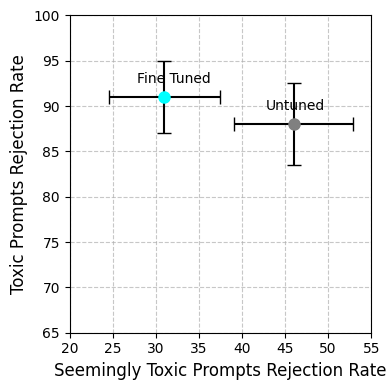

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Data points
x = [46, 31]  # Seemingly Toxic Prompts Rejection Rate
y = [88, 91]  # Toxic Prompts Rejection Rate
labels = ['Untuned', 'Fine Tuned']
N = 200  

# Calculate 95% confidence intervals for percentages
def confidence_interval(p, n, confidence=0.95):
    """Calculate confidence interval for percentage p with sample size n"""
    z = stats.norm.ppf((1 + confidence) / 2)
    std_err = np.sqrt(p * (100 - p) / n) 
    return z * std_err

# Calculate error bars (95% confidence intervals)
x_err = [confidence_interval(x_val, N) for x_val in x]
y_err = [confidence_interval(y_val, N) for y_val in y]

# Create figure and axis
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the data points
colors = ['gray', 'cyan']
markers = ['o', 'o']
for i in range(len(x)):
    ax.errorbar(x[i], y[i], xerr=x_err[i], yerr=y_err[i], fmt=markers[i], 
                capsize=5, ecolor='black', c=colors[i], markersize=8, label=labels[i])
#    ax.scatter(x[i], y[i], s=100, c=colors[i], marker=markers[i], label=labels[i])
    ax.annotate(labels[i], (x[i], y[i]), xytext=(-20, 10), textcoords='offset points')

# Labels and title
ax.set_xlabel('Seemingly Toxic Prompts Rejection Rate', fontsize=12)
ax.set_ylabel('Toxic Prompts Rejection Rate', fontsize=12)

# Set axis limits
ax.set_xlim(20, 55)
ax.set_ylim(65, 100)

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)



plt.tight_layout()
plt.savefig('overrefusal.png', dpi=300)
plt.show()